# Patterns of Life
*Alice Reinaudo, Jonas Halstrup*

In this project, we try to answer questions by means of visualization that are part of the [VAST Challenge 2017](http://vacommunity.org/VAST+Challenge+2017). We chose not to solve the entire challenge, but instead focus on one of the proposed mini-challenges. Our task is to try and identify possible causes of a decline in nesting of a popular local bird within a nature preserve. A dataset is provided containing information about the movements of several kinds of vehicles. A mix of analytical and visual methods are used in order to solve the challenge.

## Hypotheses

We want to mine the data in order to find repeating patterns, both daily and longer. In order to succeed with the mining process, we need to formulate some questions, so that we know what to look for. The main difficulty in this case is working with the time and dates, as some patterns could repeat every arbitrary numbers of hours, days, or weeks.

* Is there an event that happens every week on a certain day? Every day at a certain time?
* How do rangers behave, what paths do they follow and when? Does anyone of them behave suspiciously?
* What do campers usually do? How long do they stop?
* Does anyone drive off the roads?

What we are most interested in are the odd patterns, that is the outliers, which may indicate odd activities being carried out. The following is the map of the check-in locations of the preserve. In order to keep the visualization clean and the labels readable, we do not include the roads between the checkpoints. However, we have that data and will use it in order to work with transition information.

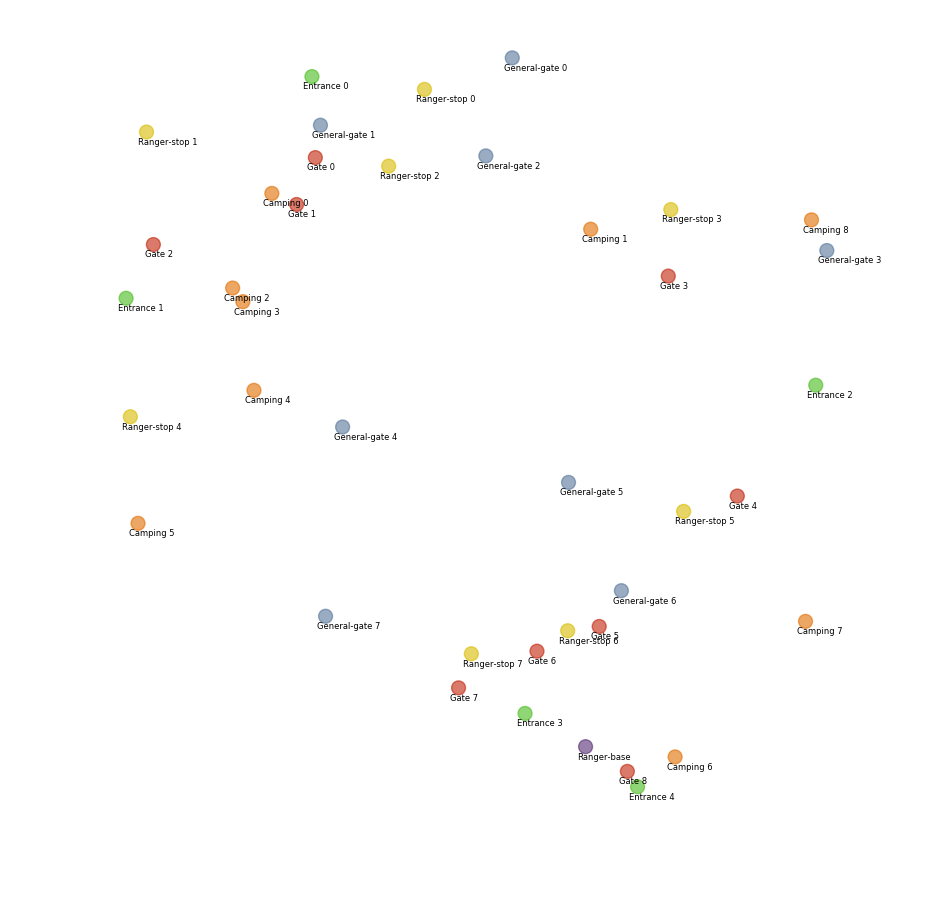

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
#import plotly.plotly as py
import pandas as pd
locations = pd.read_csv("coordinates.csv")
def make_map(size=100,props=None):
    fig, ax = plt.subplots(figsize=(11, 11))
    # Colormap, following the colors of original map
    c = ['#557599']*8+['#49bc1c']*5+['#c12209']*9+['#d8bb00']*8+['#e26d00']*9+['#562c72']
    if props == None:
        sc = ax.scatter(locations['x'],locations['y'],s=size,c=c,alpha=0.6,edgecolor=c)
    else:
        # Make a list
        allsizes = []
        for i, row in locations.iterrows():
            allsizes.append(props[row['place-name'].lower().replace(" ", "")]+1)
        sc = ax.scatter(locations['x'],locations['y'],s=np.array(allsizes)*3+10,c=c,alpha=0.6,edgecolor=c)
    #print(locations['place-name'][1])
    for i, txt in enumerate(locations['place-name']):
        #print(txt)
        ax.annotate(txt,(locations['x'][i]-10,locations['y'][i]+15),size=6)
    ax.axis('off')
    pylab.xlim([0,1000])
    pylab.ylim([0,1000])
    #plt.plot([locations.ix[0]['x'],locations.ix[2]['x']],
    #         [locations.ix[0]['y'],locations.ix[2]['y']],
    #         marker='+',color='#757575',linestyle='-',markeredgewidth=0.0,alpha=1)
    plt.gca().invert_yaxis()
make_map()
plt.show()

As a first step we load the data and append a new feature to the data frame to denote the weekday. The information is of course already encoded implicitly in the data, but adding this feature spares us from possibly recalculating the weekday many times.

In [2]:
import datetime
import calendar
df = pd.read_csv("Lekagul Sensor Data.csv")
df['date'], df['time'] = zip(*df['Timestamp'].apply(lambda x: x.split(' ')))
del df['Timestamp']
print df[:10]
weekdays = []
for index, row in df.iterrows():
    timestamp = datetime.datetime.strptime(row['date'], '%Y-%m-%d')
    weekdays.append(calendar.day_name[timestamp.weekday()])
df['weekday'] = weekdays
df = df[['date', 'weekday', 'time', 'car-id', 'car-type', 'gate-name']]
print df[:10]

               car-id car-type      gate-name        date      time
0  20154301124328-262        4      entrance3  2015-05-01  00:43:28
1  20154301124328-262        4  general-gate1  2015-05-01  01:03:48
2  20154301124328-262        4   ranger-stop2  2015-05-01  01:06:24
3  20154301124328-262        4   ranger-stop0  2015-05-01  01:09:25
4  20154301124328-262        4  general-gate2  2015-05-01  01:12:36
5  20154301124328-262        4  general-gate5  2015-05-01  01:24:02
6  20153101013141-937        1      entrance3  2015-05-01  01:31:41
7  20154301124328-262        4      entrance4  2015-05-01  01:33:57
8  20153101013141-937        1  general-gate1  2015-05-01  01:53:34
9  20153101013141-937        1   ranger-stop2  2015-05-01  01:56:20
         date weekday      time              car-id car-type      gate-name
0  2015-05-01  Friday  00:43:28  20154301124328-262        4      entrance3
1  2015-05-01  Friday  01:03:48  20154301124328-262        4  general-gate1
2  2015-05-01  Friday  0

### Daily patterns

First, we try to find out where people tend to be at different times during the day. In the following visualization, we see how many vehicles are checking in in given hourly time intervals.

In [66]:
# Pass through the data, make new dataframe for each plot
# 23... 24 (0)
from collections import defaultdict
intvdata = dict()
for i in range(0,24):
    intvdata[str(i)+'-'+str(i+1)] = defaultdict(int)
    startime = datetime.time(i)
    if i < 23:
        endtime = datetime.time(i+1)
    else:
        endtime = datetime.time(23, 59, 59)
    for j, row in df.iterrows():
        evtime = datetime.datetime.strptime(row['time'],'%H:%M:%S')    
        if evtime.time() > startime and evtime.time() <= endtime:
            intvdata[str(i)+'-'+str(i+1)][row['gate-name']] += 1

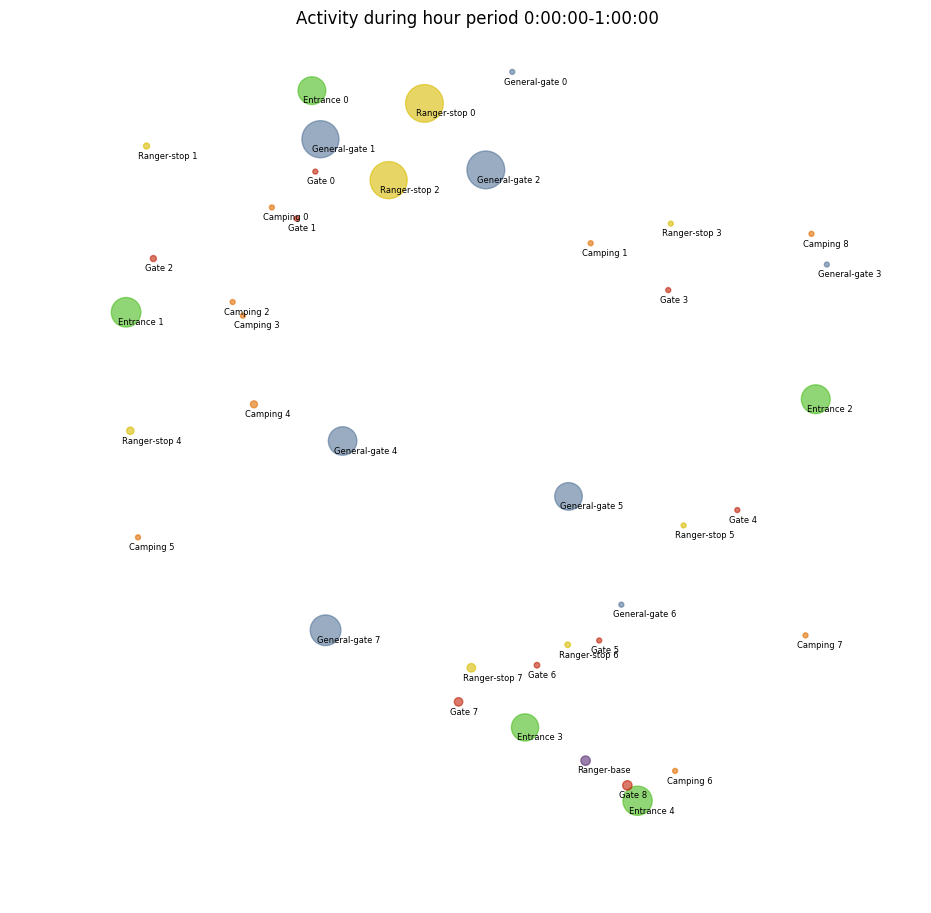

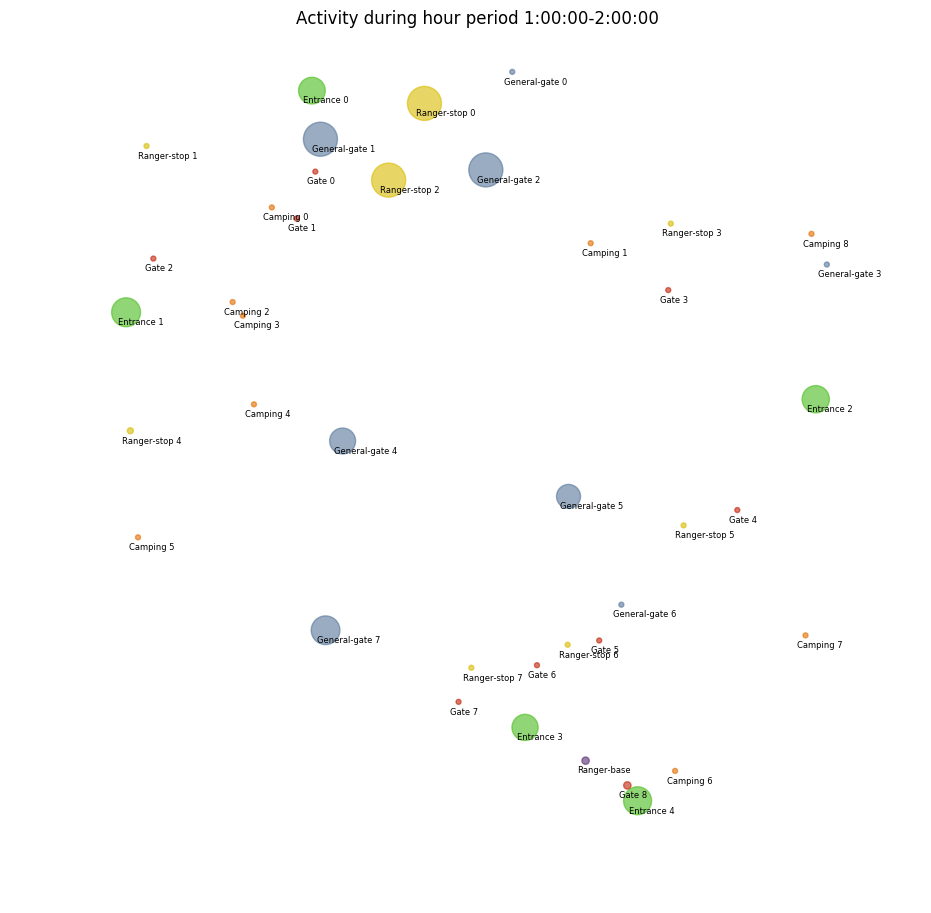

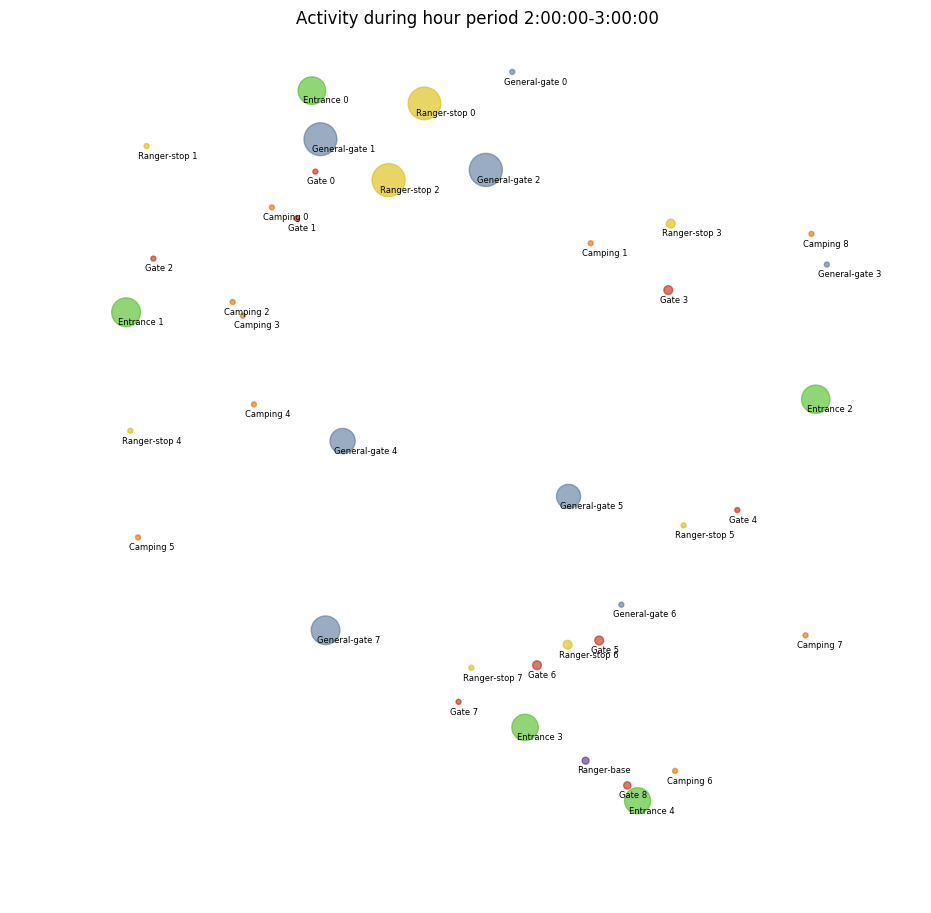

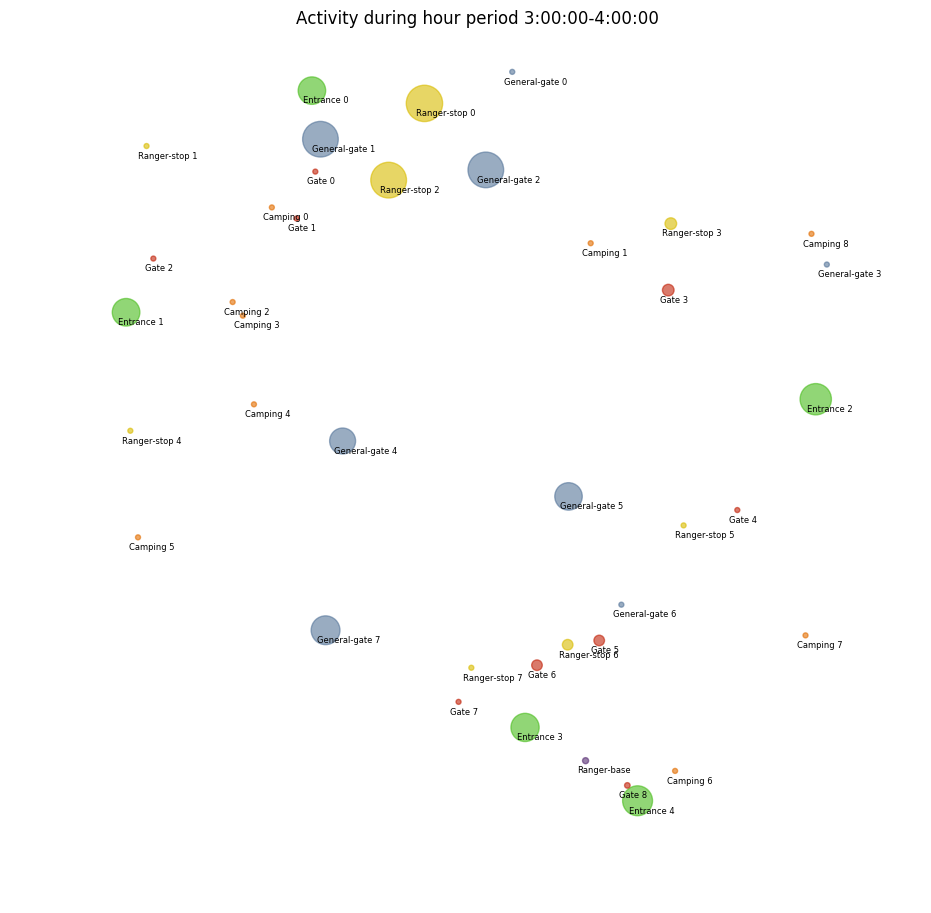

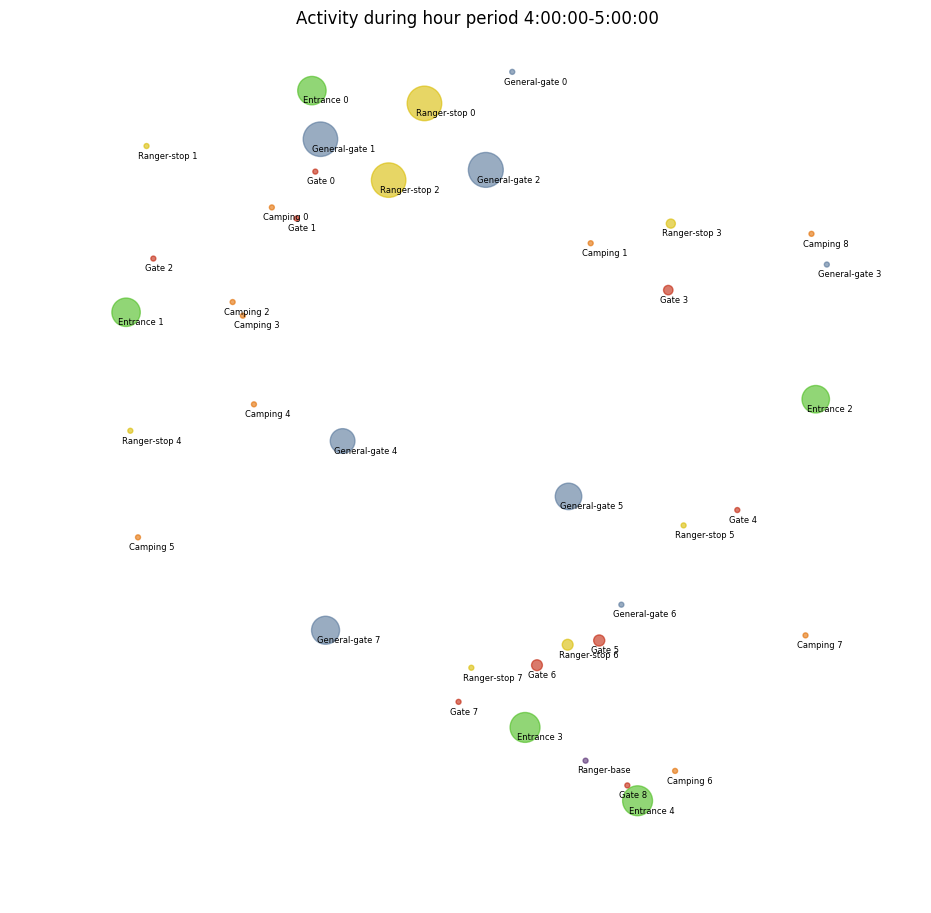

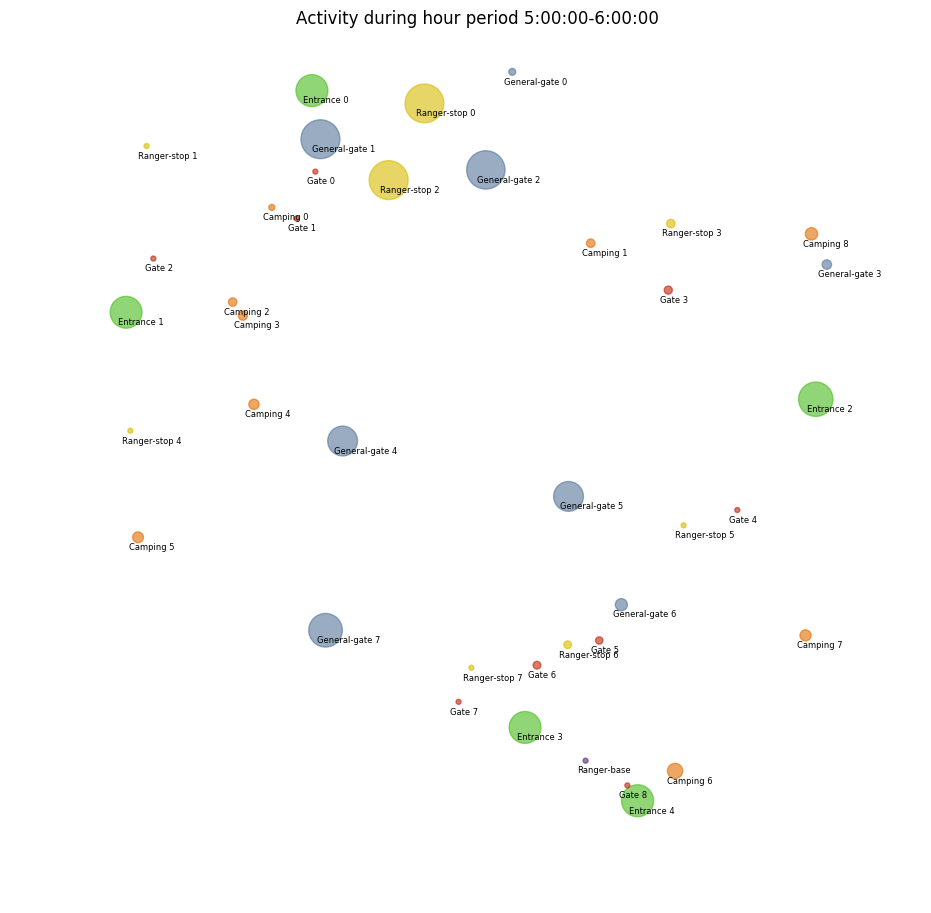

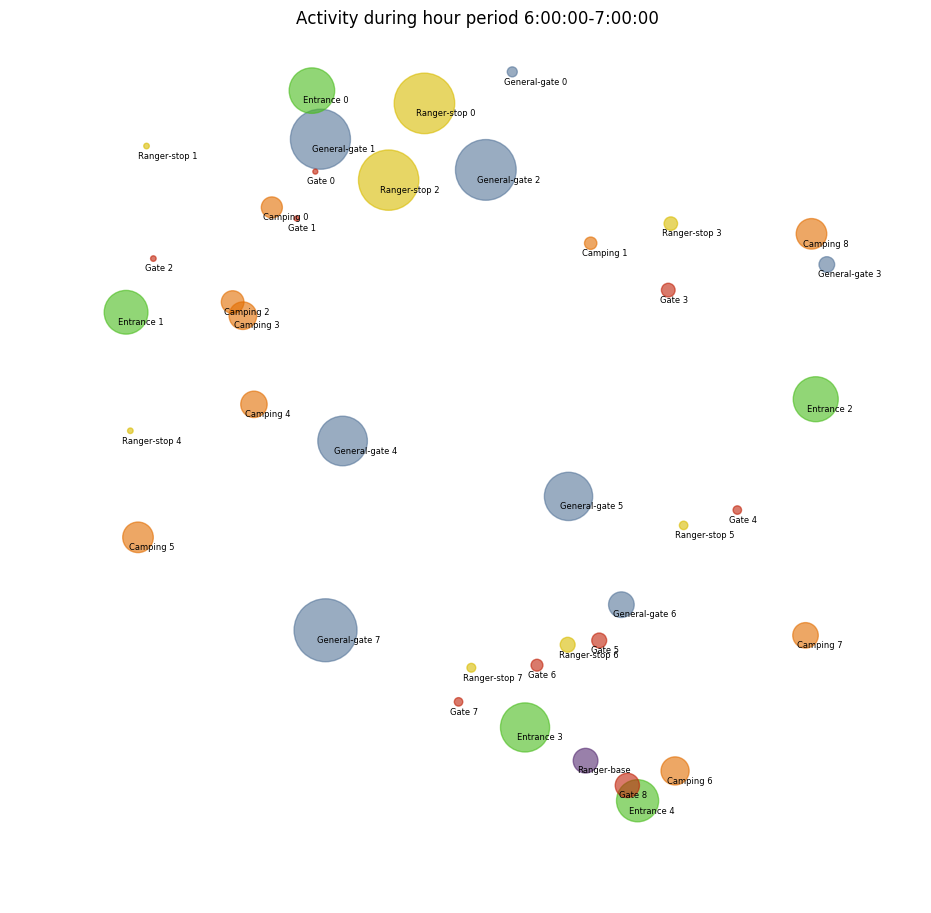

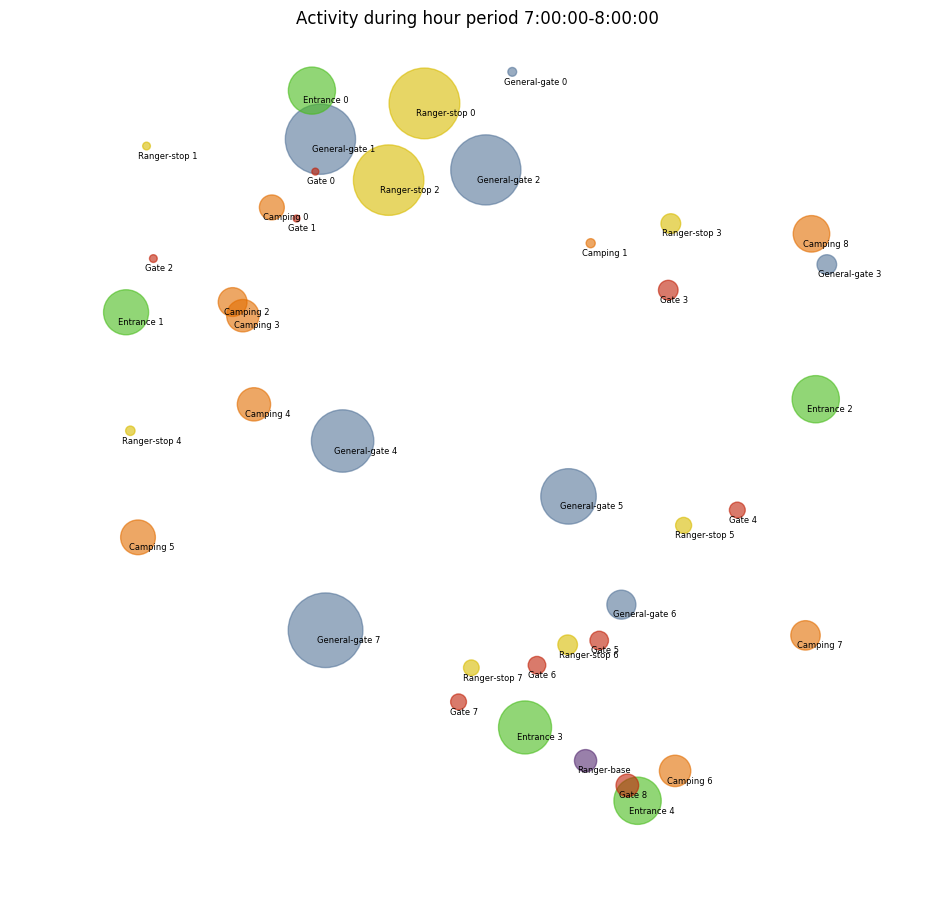

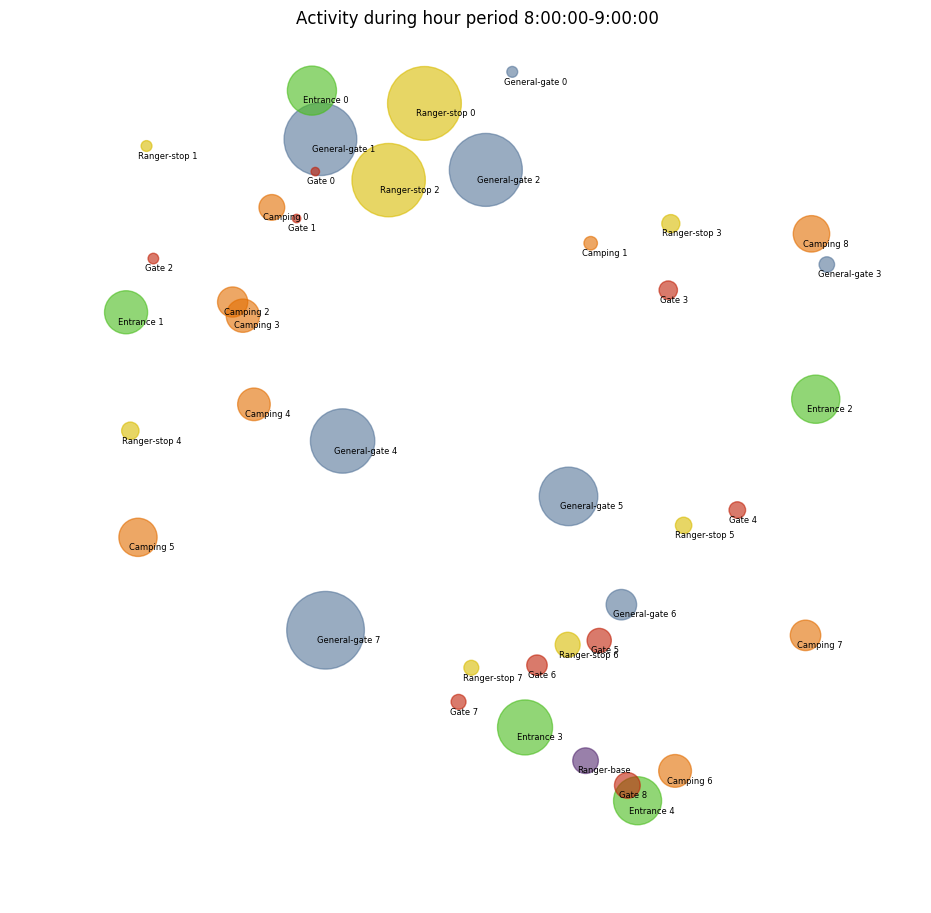

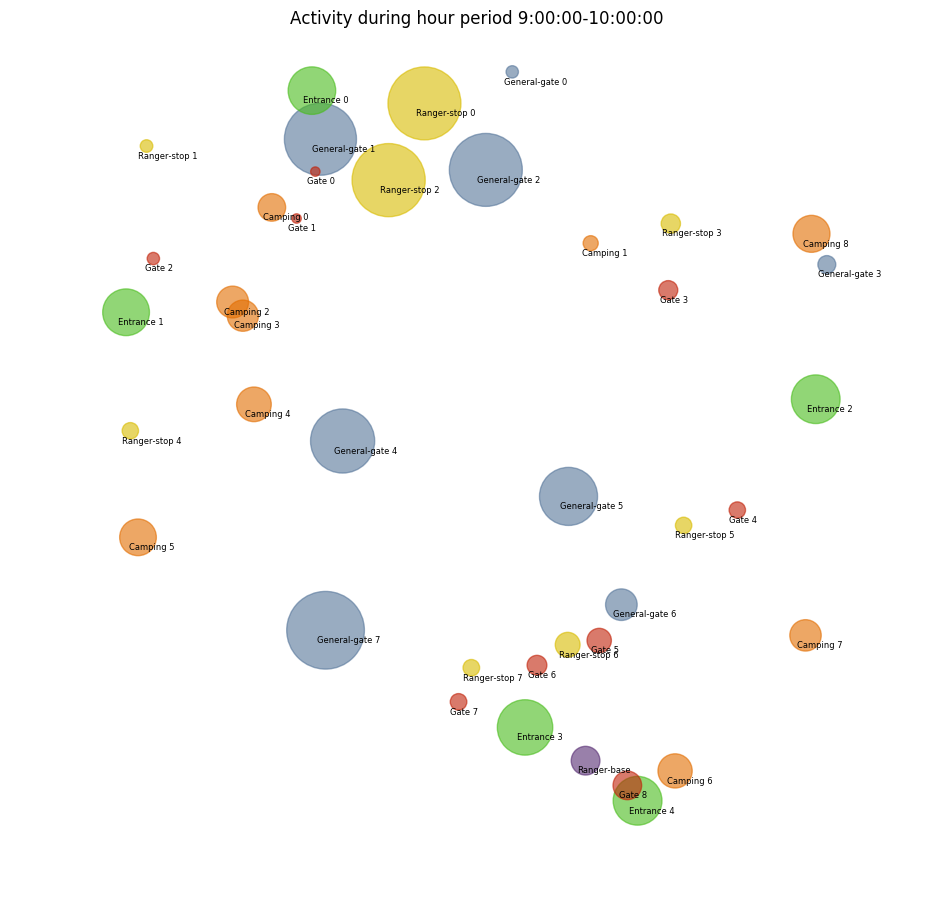

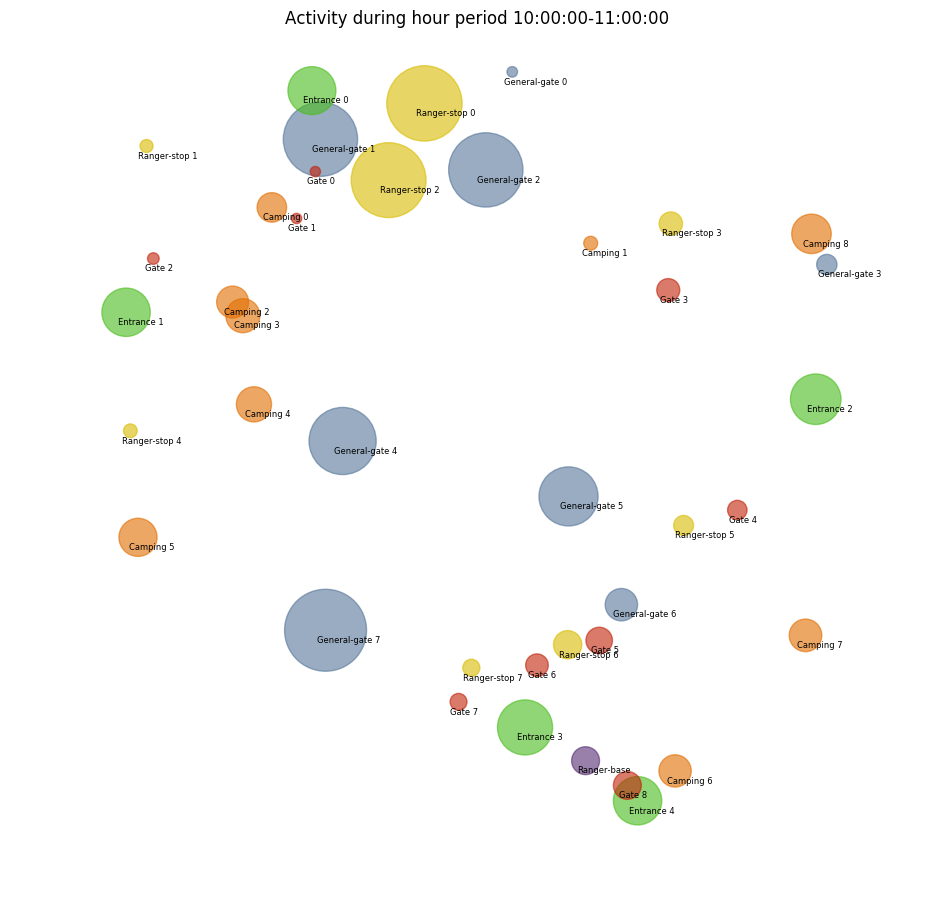

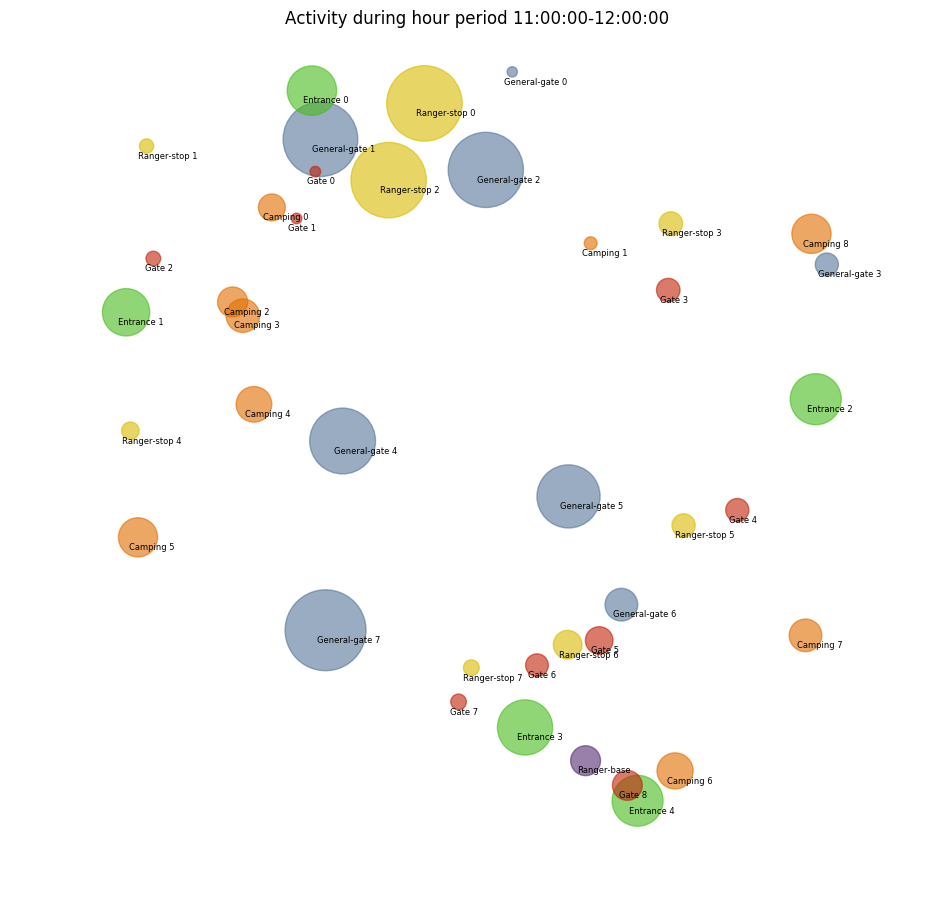

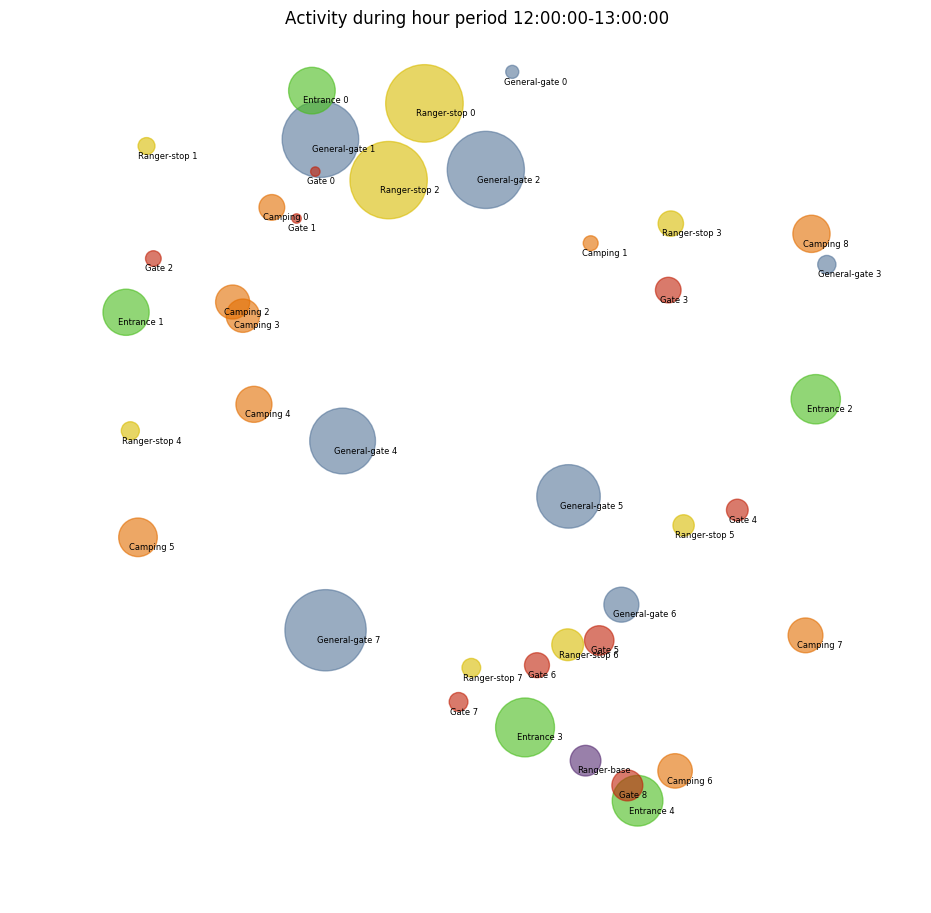

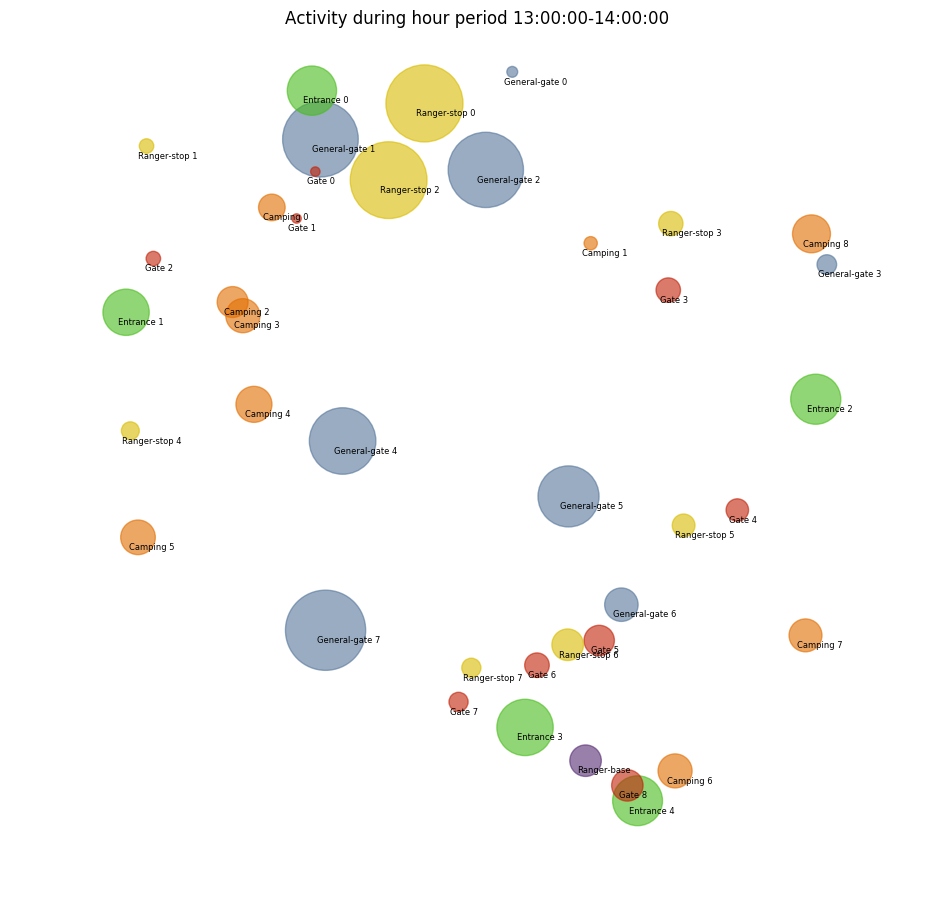

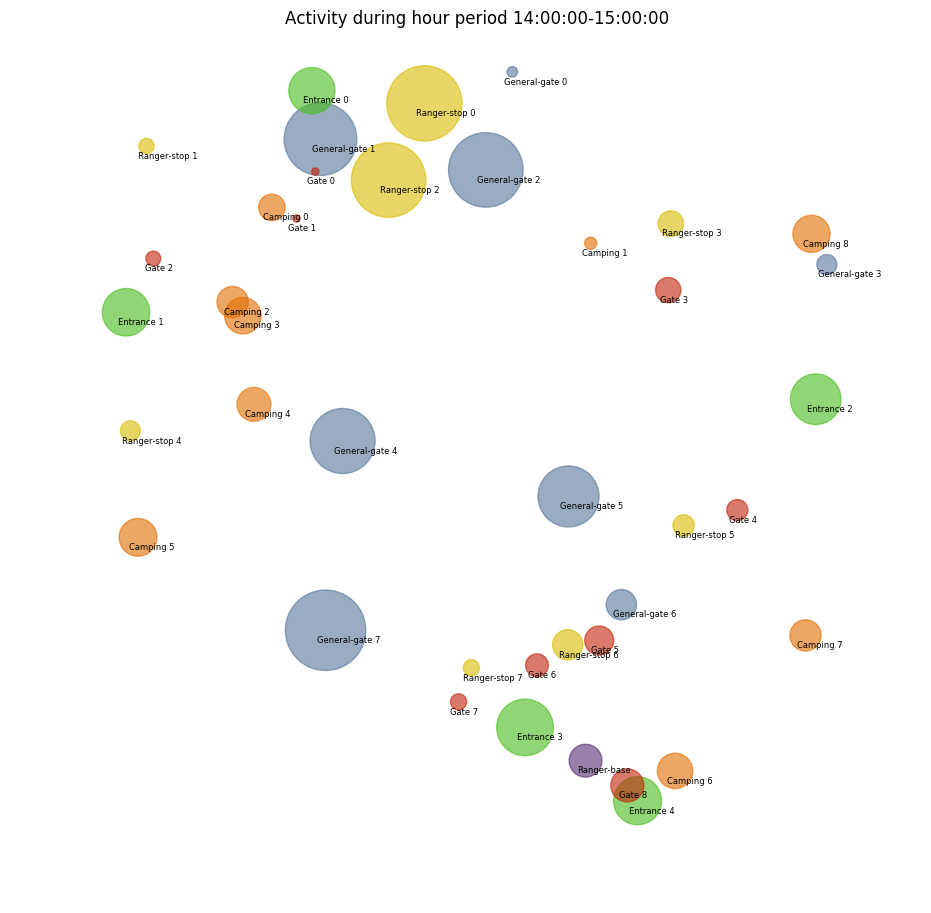

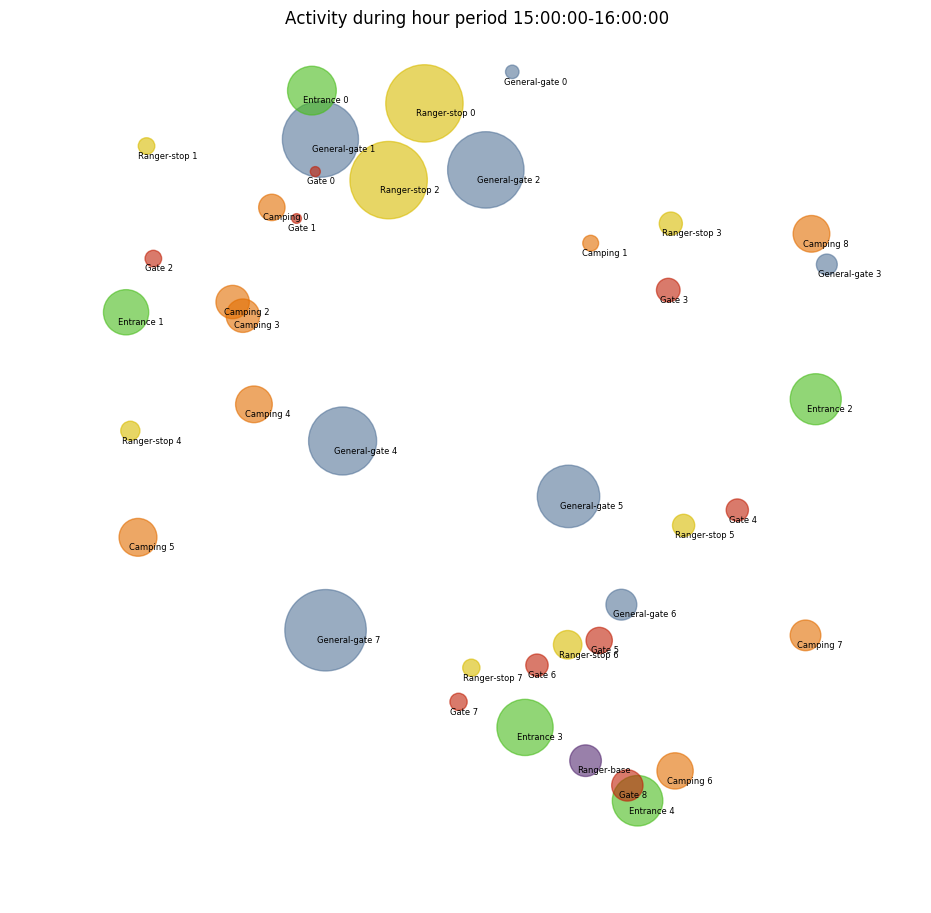

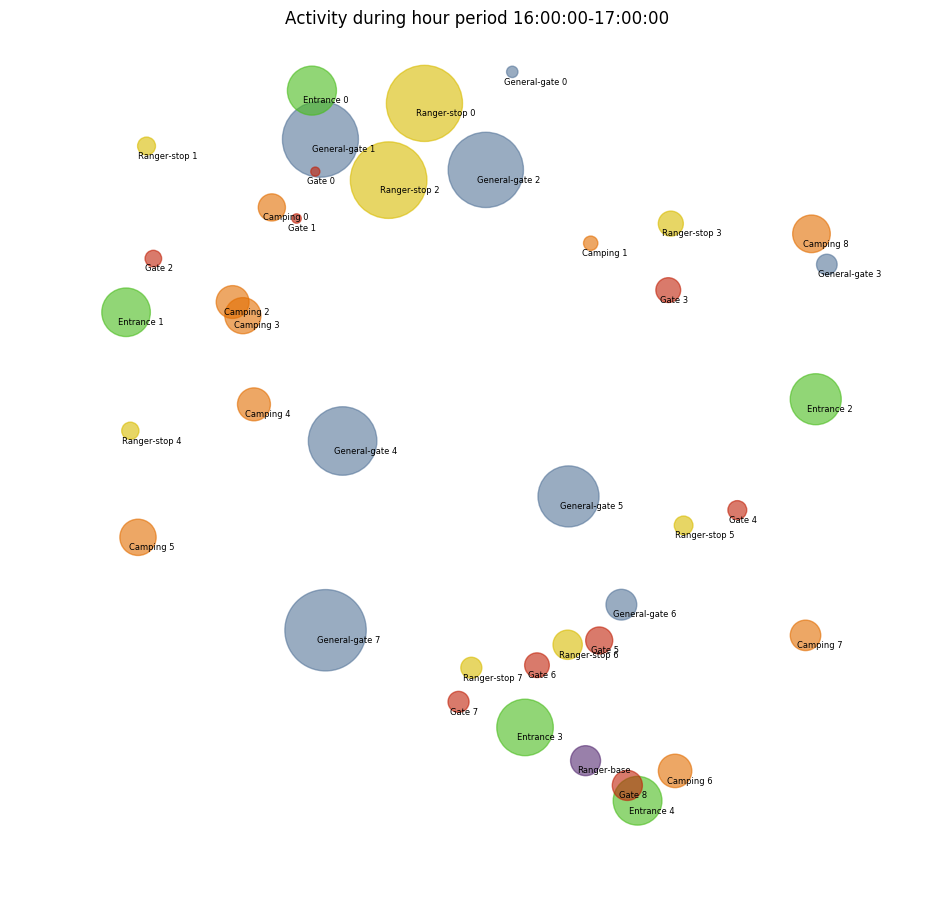

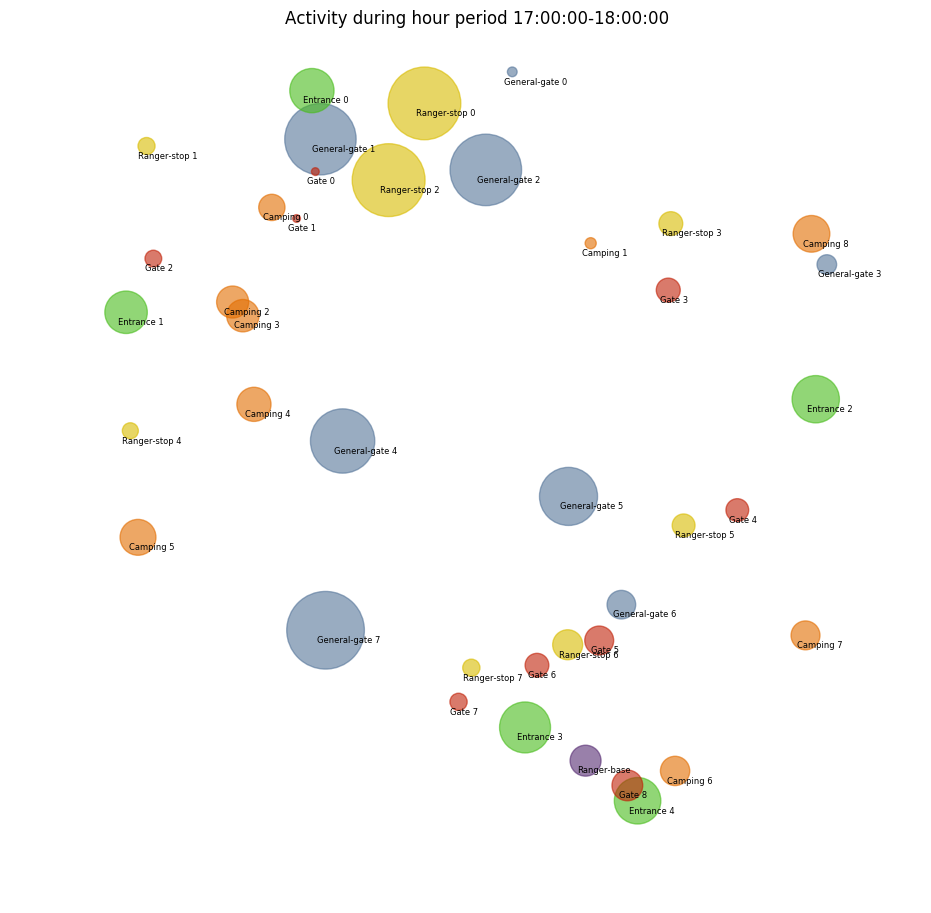

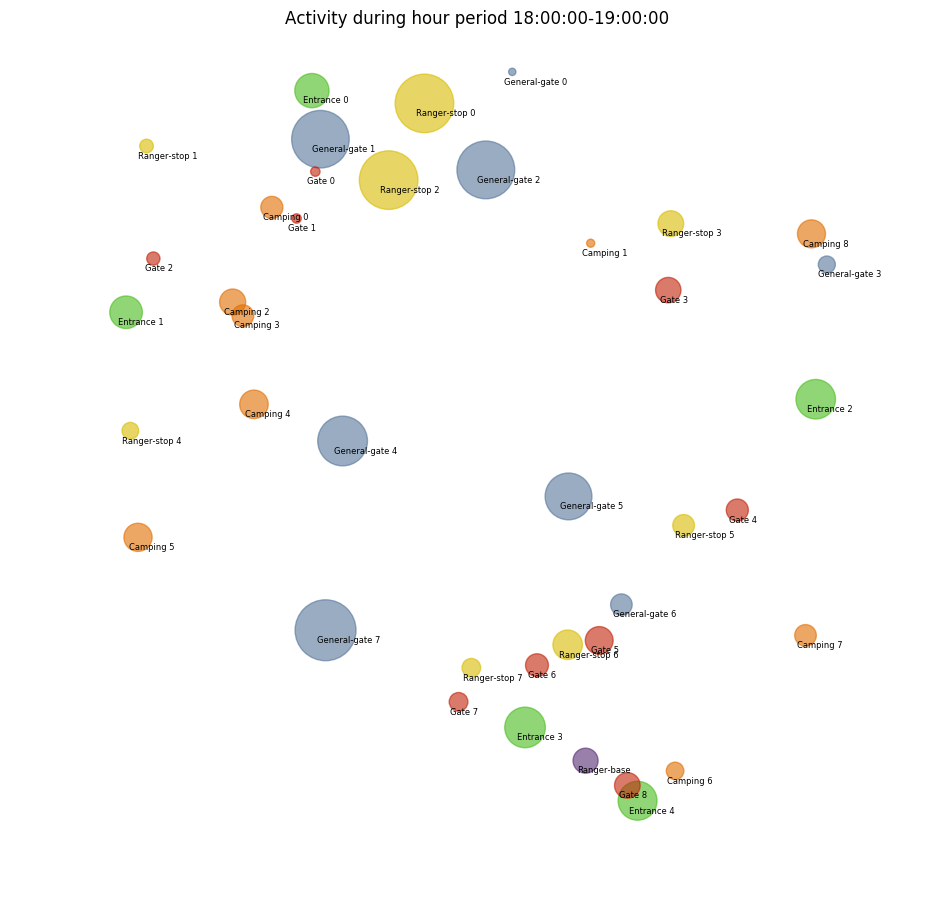

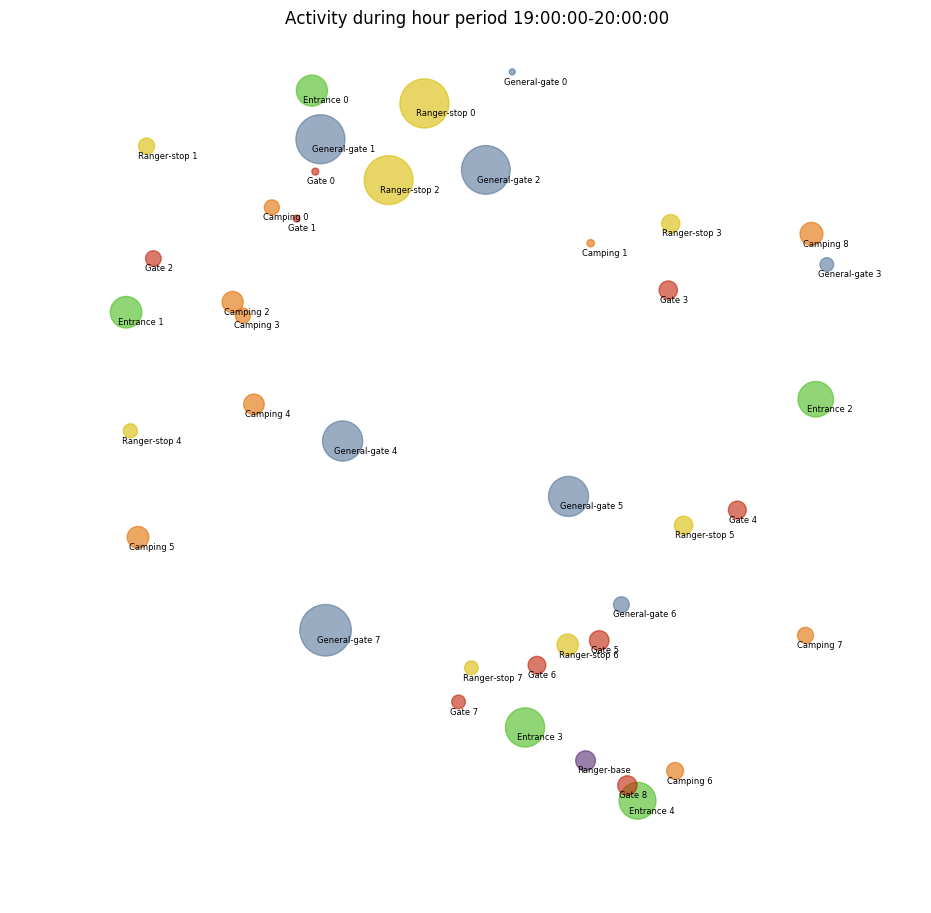

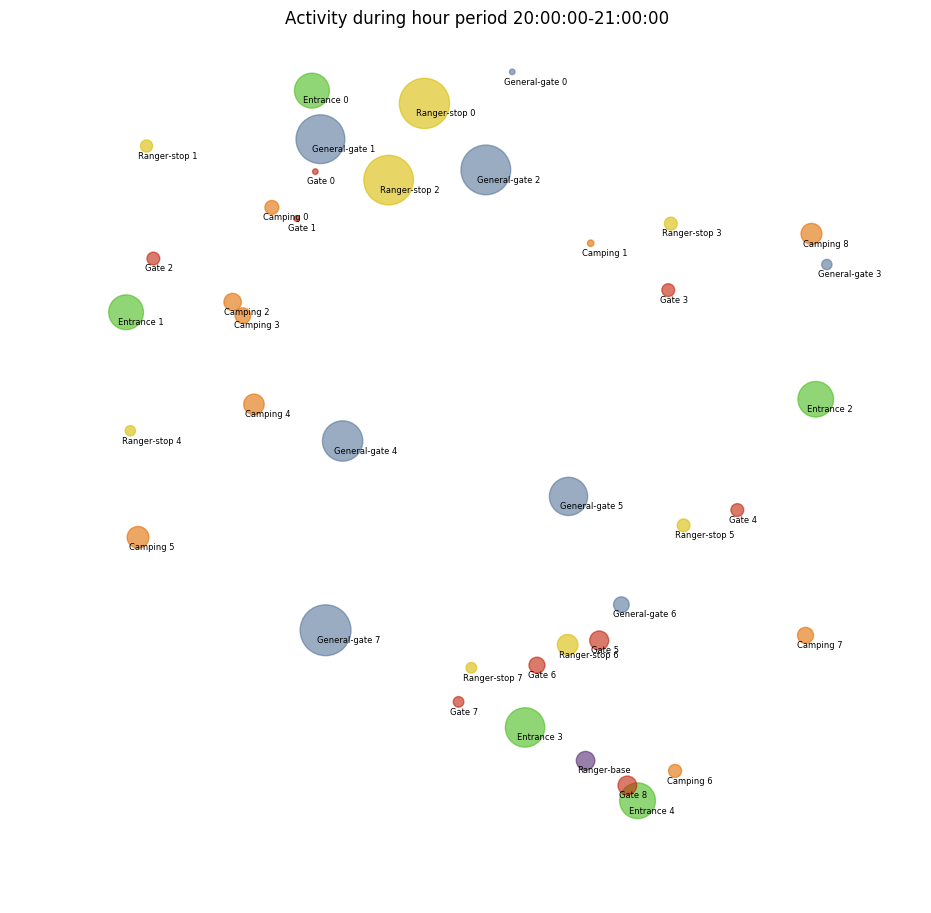

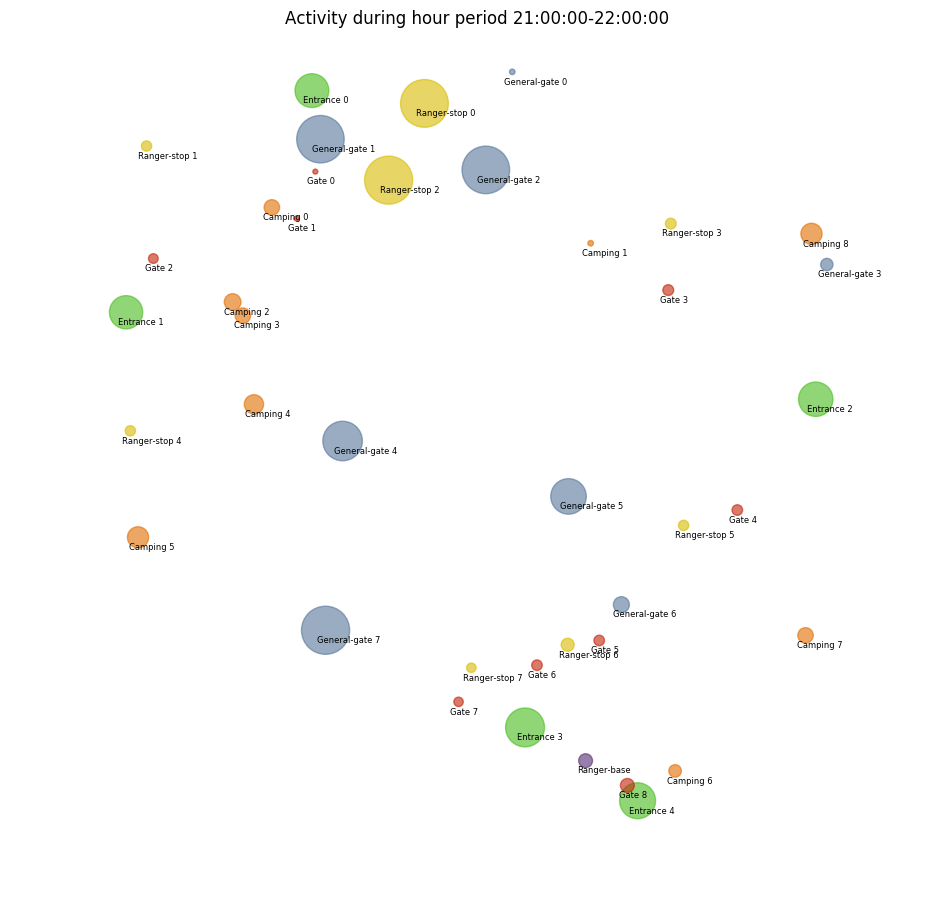

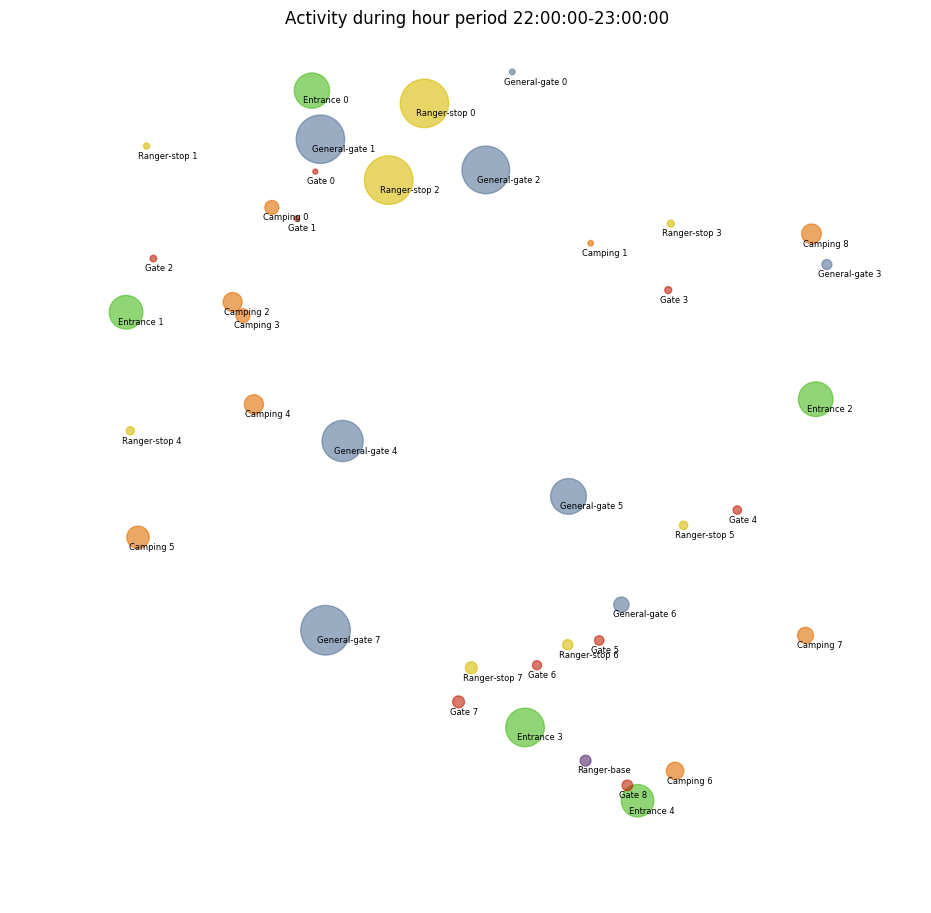

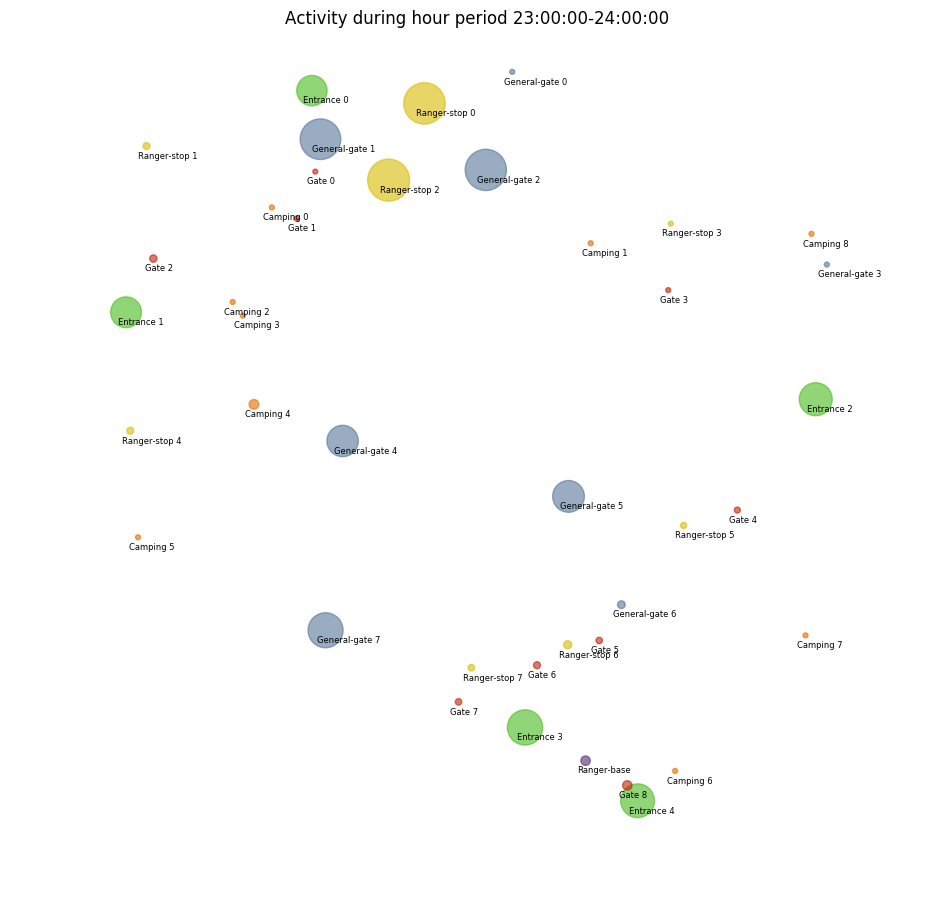

In [65]:
for i in range(0,24):
    make_map(props=intvdata[str(i)+'-'+str(i+1)])
    pylab.title('Activity during hour period %s:00:00-%s:00:00'%(i,i+1))
    plt.show()

The above is aggregate data, in the sense that we show the visualizations of the sum of all check-ins over certain time intervals, without looking (yet) for patterns regarding any vehicle in particular, nor patterns consisting of transitions. Nevertheless we can see some interesting trends in the data. The following are some aggregate patterns that we can infer.

**Daily pattern 1.** At night, most check-ins occur within general gates, entrances and ranger stops throughout the map, and in particular in the northern region of the preserve. This suggests that rangers are active around the clock.
*Further exploration:* is it only rangers that are active at this time? Are they following a predefined path? Why are the southern ranger stops almost not used at all?

**Daily pattern 2.** Other zones like gates and campings hardly show any sign of movement. This is understandable, as most campers would be asleep at that time. In particular, camping check-ins stop abruptly around 23pm and begin around 6am.

**Daily pattern 3.** All entrances seem to be actively used around the clock, albeit slightly less at night suggesting that there is someone entering and exiting the preserve at any time. *Further exploration:* who is mostly active at night, and which paths do they follow? What are they doing?

A first hypothesis we can make with regards to the decline in bird nesting, is that there seems to be incessant activity throughout the preserve at all times of the day. It can be that the noise is keeping many birds awake, and ruining their chances to nest.

### Weekly patterns